In [1]:
pip install mlrose_hiive

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for mlrose-hiive: filename=mlrose_hiive-2.1.3-cp36-none-any.whl size=96602 sha256=4ecc6d01531a65c6b272861f1a4fbd5023fa783b74968c6bda0f88ddfaedb31e
  Stored in directory: /root/.cache/pip/wheels/ee/ef/8b/941402c2014649279f68a1ed4a37b4d15142dfb9c7e4a6b7ac
Successfully built mlrose-hiive


# Imports

In [0]:
import mlrose_hiive
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [0]:
def generate_graph(filename, title, x_label, y_label):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # plt.legend()
    plt.show()
    plt.savefig(filename)
    plt.close()

# Generate weights & values for knapsack problem

In [48]:
np.random.seed(121)
N = 10
weights = np.random.uniform(size=N)
values = np.arange(1, N+1, 1)
# max_weight_pct = 0.8
print('weights: ', weights)
print('values: ', values)

weights:  [0.11133083 0.21076757 0.23296249 0.15194456 0.83017814 0.40791941
 0.5557906  0.74552394 0.24849976 0.9686594 ]
values:  [ 1  2  3  4  5  6  7  8  9 10]


# Algorithms

In [0]:
"""
np.random.seed(SEED)
N = 20
fitness = mlrose.Knapsack(weights=np.random.uniform(size=N), values=np.arange(1, N+1, 1),max_weight_pct=0.8)
problem_fit = mlrose.DiscreteOpt(length = N,fitness_fn = fitness,maximize = True,max_val = 2 # binary)
"""

# Count function evaluation counts
def ks_fitness_fn(state):
    global eval_count
    """
    N = 5
    weights = [10, 5, 2, 8, 15]
    values =  [1, 2, 3, 4, 5]
    max_weight_pct = 0.8
    """
    N = 10
    weights = [0.11133083, 0.21076757, 0.23296249, 0.15194456, 0.83017814, 0.40791941,
              0.5557906,  0.74552394, 0.24849976, 0.9686594 ]
    values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    max_weight_pct = 0.8
    fitness = mlrose_hiive.Knapsack(weights=weights, values=values, max_weight_pct=max_weight_pct)
    eval_count += 1
    return fitness.evaluate(state)

def rhc(problem, iterations, random_seed, graph_file, graph_title):
    fitness = []
    fit_time = []
    fn_evals = []
    global eval_count
    for i in iterations:
        eval_count = 0
        start = datetime.datetime.now()
        best_state, best_fitness, _ = mlrose_hiive.random_hill_climb(problem,
                                   max_iters=i, random_state=random_seed)
        finish = datetime.datetime.now()
        fitness.append(best_fitness)
        fit_time.append((finish - start).total_seconds())
        fn_evals.append(eval_count)

    plt.plot(iterations, fitness, label="Fitness score")
    plt.legend(loc="best")
    plt.grid()
    generate_graph(graph_file + "rhc", graph_title + "Random Hill Climbing",
                   "Iterations", "Fitness")
    print('Best score achieved: ', max(fitness))
    index = fitness.index(max(fitness))
    print('Time taken to achieve that: ', fit_time[index])
    print('Function evaluations taken to achieve that: ', fn_evals[index])

def sa(problem, iterations, random_seed, graph_file, graph_title):
    decays = [0.001, 0.002, 0.003, 0.004, 0.005]
    best_score = []
    time_taken = []
    fn_evals_taken = []
    # fig1, ax1 = plt.subplots()
    # fig2, ax2 = plt.subplots()
    global eval_count
    for decay in decays:
        schedule = mlrose_hiive.ArithDecay(init_temp=1.0, decay=decay)
        fitness = []
        fit_time = []
        fn_evals = []
        for i in iterations:
            eval_count = 0
            start = datetime.datetime.now()
            # Solve using simulated annealing - attempt 1
            best_state, best_fitness, _ = mlrose_hiive.simulated_annealing(problem, schedule=schedule,
                                                                max_iters=i, random_state=random_seed)
            finish = datetime.datetime.now()
            fn_evals.append(eval_count)
            fitness.append(best_fitness)
            fit_time.append((finish - start).total_seconds())
            # print('iteration: ',i)
            # print('best_state:', best_state)
            # print('best_fitness: ', best_fitness)
        best_score.append(max(fitness))
        index = fitness.index(max(fitness))
        time_taken.append(fit_time[index])
        fn_evals_taken.append(fn_evals[index])
        # print('index: ', index)
        # print('time for that: ', fit_time[index])
        plt.plot(iterations, fitness, label="Cooling = " + str(decay))
        # ax2.plot(fn_evals, fitness, label="Cooling = " + str(decay))

    plt.legend(loc="best")
    plt.grid()
    generate_graph(graph_file + "sa_iter", graph_title + "Simulated Annealing", "Iterations", "Fitness")

    """
    ax2.legend(loc="best")
    ax2.grid()
    generate_graph("cp_sa_evals", "Continuous Peaks - Simulated Annealing", "Function evaluations", "Fitness")
    """
    # Decays best_score and time_taken
    plt.plot(decays, best_score)
    plt.grid()
    generate_graph(graph_file + "sa_decays", graph_title + "Simulated Annealing",
                   "Cooling Component", "Best Score Achieved")

    plt.plot(decays, time_taken)
    plt.grid()
    generate_graph(graph_file + "sa_decay_time", graph_title + "Simulated Annealing",
                   "Cooling Component", "Time taken to achieve that")

    plt.scatter(time_taken, best_score)
    for i, txt in enumerate(decays):
        plt.annotate(s=str(txt), xy=(time_taken[i], best_score[i]))
    plt.legend(loc='best', title='Cooling Component')
    plt.grid()
    generate_graph(graph_file + "sa_scatter", graph_title + "Simulated Annealing",
                   "Time Taken", "Best Score achieved")

    print('decays: ', decays)
    print('Best scores reached: ', best_score)
    print('Time taken to do that: ', time_taken)
    print('Function evaluations taken: ', fn_evals_taken)

def ga(problem, iterations, random_seed, graph_file, graph_title):
    mutation_prob = [0.1, 0.2, 0.3, 0.4, 0.5]
    best_score = []
    time_taken = []
    fn_evals_taken = []
    global eval_count
    for m in mutation_prob:
        fitness = []
        fit_time = []
        fn_evals = []
        for i in iterations:
            eval_count = 0
            start = datetime.datetime.now()
            best_state, best_fitness, _ = mlrose_hiive.genetic_alg(problem, mutation_prob=m,
                                                                max_iters=i, random_state=random_seed)
            finish = datetime.datetime.now()
            fitness.append(best_fitness)
            fit_time.append((finish - start).total_seconds())
            fn_evals.append(eval_count)
        # Find the best score achieved in that mutation prob
        best_score.append(max(fitness))
        index = fitness.index(max(fitness))
        # find the time that was taken to achieve that
        time_taken.append(fit_time[index])
        fn_evals_taken.append(fn_evals[index])
        plt.plot(iterations, fitness, label="Mutation = " + str(m))

    plt.legend(loc="best", title='Mutation Probability')
    plt.grid()
    generate_graph(graph_file + "ga", graph_title + "Genetic Algorithm", "Iterations", "Fitness")

    # Decays best_score and time_taken
    plt.plot(mutation_prob, best_score)
    plt.grid()
    generate_graph(graph_file + "ga_mut", graph_title + "Genetic Algorithm",
                   "Mutation Probability", "Best Score Achieved")

    """
    plt.plot(mutation_prob, time_taken)
    plt.grid()
    generate_graph("cp_sa_decay_time", "Continuous Peaks - Genetic Algorithm", "Mutation Probability",
                   "Time taken to achieve that")
    """

    plt.scatter(time_taken, best_score)
    for i, txt in enumerate(mutation_prob):
        plt.annotate(s=str(txt), xy=(time_taken[i], best_score[i]))
    plt.legend(loc='best', title='Mutation Probability')
    plt.grid()
    generate_graph(graph_file + "ga_scatter", graph_title + "Genetic Algorithm",
                   "Time Taken", "Best Score achieved")

    print('Mutation prob: ', mutation_prob)
    print('Best scores reached: ', best_score)
    print('Time taken to do that: ', time_taken)
    print('Function evaluations taken: ', fn_evals_taken)

def mimic(problem, iterations, random_seed, graph_file, graph_title):
    keep_pct = [0.1, 0.25, 0.50]
    best_score = []
    time_taken = []
    fn_evals_taken = []
    global eval_count
    for k in keep_pct:
        fitness = []
        fit_time = []
        fn_evals = []
        for i in iterations:
            eval_count = 0
            start = datetime.datetime.now()
            best_state, best_fitness, _ = mlrose_hiive.mimic(problem, keep_pct=k,
                                                            max_iters=i, random_state=random_seed)
            finish = datetime.datetime.now()
            fitness.append(best_fitness)
            fit_time.append((finish - start).total_seconds())
            fn_evals.append(eval_count)
        # Find the best score achieved in that mutation prob
        best_score.append(max(fitness))
        index = fitness.index(max(fitness))
        # find the time that was taken to achieve that
        time_taken.append(fit_time[index])
        fn_evals_taken.append(fn_evals[index])
        plt.plot(iterations, fitness, label="keep_pct = " + str(k))

    plt.legend(loc="best", title='Proportion of samples kept')
    plt.grid()
    generate_graph(graph_file + "mimic", graph_title + "MIMIC: ", "Iterations", "Fitness")

    # Decays best_score and time_taken
    plt.plot(keep_pct, best_score)
    plt.grid()
    generate_graph(graph_file + "mimic_pct", graph_title + "MIMIC",
                   "Proportion of samples kept", "Best Score Achieved")

    """
    plt.plot(mutation_prob, time_taken)
    plt.grid()
    generate_graph("cp_sa_decay_time", "Continuous Peaks - Genetic Algorithm", "Mutation Probability",
                   "Time taken to achieve that")
    """

    plt.scatter(time_taken, best_score)
    for i, txt in enumerate(keep_pct):
        plt.annotate(s=str(txt), xy=(time_taken[i], best_score[i]))
    plt.legend(loc='best', title='Proportion of samples kept')
    plt.grid()
    generate_graph(graph_file + "mimic_scatter", graph_title + "MIMIC",
                   "Time Taken", "Best Score achieved")

    print('Proportion of samples kept: ', keep_pct)
    print('Best scores reached: ', best_score)
    print('Time taken to do that: ', time_taken)
    print('Function evaluations taken: ', fn_evals_taken)


# Define Knapsack problem

In [60]:
# Initialize fitness function object using Custom function
fitness_fn = mlrose_hiive.CustomFitness(ks_fitness_fn)
# Define optimization problem object
N = 10
problem = mlrose_hiive.DiscreteOpt(length=N, fitness_fn=fitness_fn, maximize=True, max_val=2)
max_iters = 1500
iterations = range(0, max_iters, 50)
random_seed = 1
graph_file = 'ks_'
graph_title = 'Knapsack Problem - '
print('***************Knapsack Optimization Problem*****************')

***************Knapsack Optimization Problem*****************


# Random hill climbing

--------------Random Hill Climbing---------------


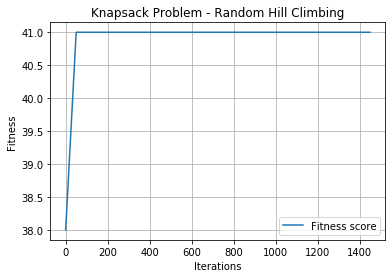

Best score achieved:  41.0
Time taken to achieve that:  0.002853
Function evaluations taken to achieve that:  18


In [61]:
# Random hill climbing
print('--------------Random Hill Climbing---------------')
rhc(problem, iterations, random_seed, graph_file, graph_title)

# Simulated annealing

--------------Simulated Annealing---------------


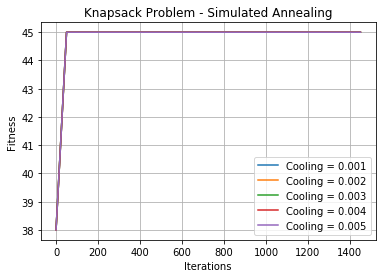

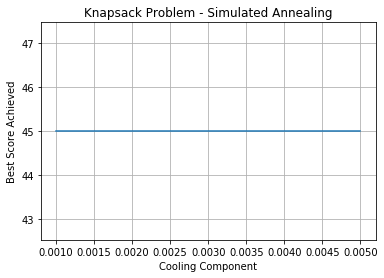

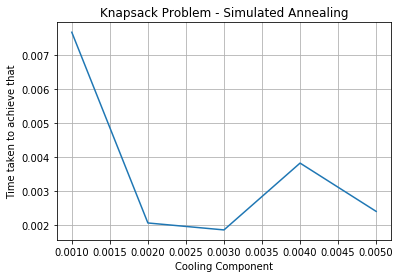

No handles with labels found to put in legend.


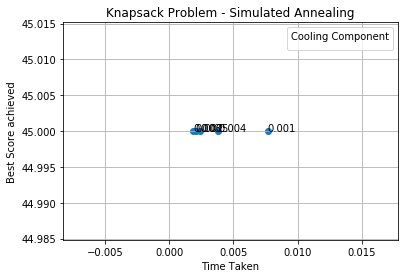

decays:  [0.001, 0.002, 0.003, 0.004, 0.005]
Best scores reached:  [45.0, 45.0, 45.0, 45.0, 45.0]
Time taken to do that:  [0.007676, 0.002073, 0.001869, 0.003832, 0.002413]
Function evaluations taken:  [28, 28, 28, 28, 28]


In [62]:
# simulate annealing
print('--------------Simulated Annealing---------------')
sa(problem, iterations, random_seed, graph_file, graph_title)

# Genetic Algorithm

--------------Genetic Algorithm---------------


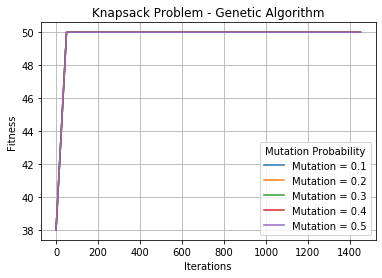

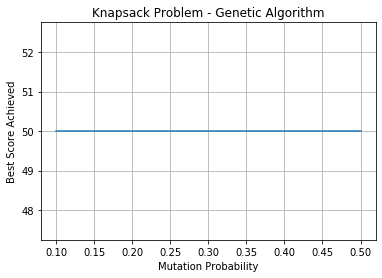

No handles with labels found to put in legend.


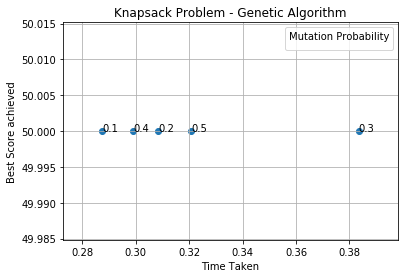

Mutation prob:  [0.1, 0.2, 0.3, 0.4, 0.5]
Best scores reached:  [50.0, 50.0, 50.0, 50.0, 50.0]
Time taken to do that:  [0.287459, 0.308467, 0.38353, 0.29904, 0.320778]
Function evaluations taken:  [2615, 2816, 3219, 2615, 2816]


In [56]:
# Genetic Algorithm
print('--------------Genetic Algorithm---------------')
ga(problem,iterations,random_seed, graph_file, graph_title)

# MIMIC

--------------MIMIC---------------


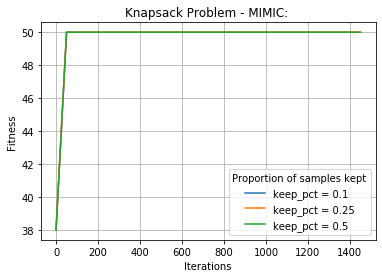

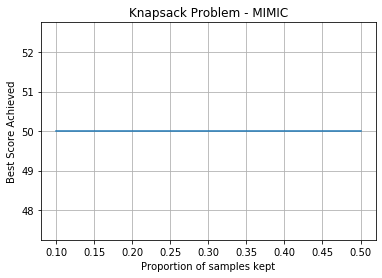

No handles with labels found to put in legend.


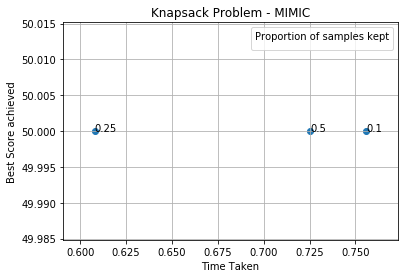

Proportion of samples kept:  [0.1, 0.25, 0.5]
Best scores reached:  [50.0, 50.0, 50.0]
Time taken to do that:  [0.755928, 0.608017, 0.725232]
Function evaluations taken:  [2413, 2413, 2615]


In [57]:
# MIMIC
print('--------------MIMIC---------------')
mimic(problem, iterations, random_seed, graph_file, graph_title)